In [1]:
import numpy as np
import pandas as pd 
from scipy.stats import norm, truncnorm
from collections import OrderedDict as odict
import emcee
import corner
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 

plt.rc('axes',lw =2)
plt.rc('text', usetex = True)
%matplotlib inline

In [2]:
dataframe = pd.read_csv('PegasusIV_CatalogLite.csv')

In [3]:
def gmr_to_vmag(g,r,dg,dr):
    '''
    Converts DELVE/DECam g,r photometry to Johnson V-band
    Agnostic to whether data has had extinction correction applied; this notebook later assumes it *has*
    '''
    v = g - 0.487 * (g - r + .1) - 0.025
    dv = np.sqrt ((1 - 0.487) * dg ** 2 + 0.487 * dr ** 2 )
    return v, dv

In [4]:
def gaia_to_vmag(gaia_g, gaia_bp, gaia_rp):
    '''
    Convert Gaia EDR3 broadband photometry (G, G_BP, G_RP) to Johnson V-band using relation
    from the Gaia EDR3 documentation:
    https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/
    
    Agnostic to whether data has had extinction correction applied; this notebook later assumes it *has NOT*
    '''
    bp_m_rp = gaia_bp - gaia_rp
    GmV = -0.02704 + (0.01424 * bp_m_rp) - (0.2156 * bp_m_rp**2) + (0.01426 * bp_m_rp**3)
    
    return -1 * (GmV - gaia_g) 

In [5]:
def derive_vmag0(dataframe):
    '''
    Derives Johnson V-band magnitudes using DECam photometry where available, or Gaia EDR3 photometry where not.
    Does *not* apply distance or extinction correction.
    '''
    vmag_array = []
    dvmag_array = []
    
    for index, row in dataframe.iterrows():
        if (row['Mem']) & (row['SNR'] > 5):
            if np.isfinite(row['EXT_CORRECTED_G']) & np.isfinite(row['EXT_CORRECTED_R']) & \
            np.isfinite(row['MAGERR_PSF_G']) & np.isfinite(row['MAGERR_PSF_R']):

                vmag, vmag_err = gmr_to_vmag(row['EXT_CORRECTED_G'], row['EXT_CORRECTED_R'], row['MAGERR_PSF_G'], row['MAGERR_PSF_R'])

            else: 
                vmag = gaia_to_vmag(row['phot_g_mean_mag'], row['phot_bp_mean_mag'], row['phot_rp_mean_mag'])
                vmag -= (3.1 * 0.06) 
                
                vmag_err = 0.1    

        else: 
            vmag, vmag_err = -99, -99

        vmag_array.append(vmag)
        dvmag_array.append(vmag_err)
    
    return np.asarray(vmag_array), np.asarray(dvmag_array)

In [6]:
vmags0_all, vmag0_errs_all = derive_vmag0(dataframe)

dm = 19.77
ddm = (0.03**2 + .1**2)**(0.5) 

dataframe['Vmag0'] = vmags0_all - dm
dataframe['Vmag0_err'] = np.sqrt(vmag0_errs_all**2 + ddm**2)

In [7]:
car13_a = -3.45
car13_b = 0.16
car13_c = 0.41
car13_d = -0.53
car13_e = 0.019

car13_da = 0.04
car13_db = 0.01
car13_dc = 0.004
car13_dd = 0.11
car13_de = 0.002

def feh_cat_all(ews, dews, M_V, dM_V):

    #CARRERA ET AL. (2013) CAT CALIBRATION TO ABSOLUTE V MAGNITUDE
    a = -3.45
    b = 0.16
    c = 0.41
    d = -0.53
    e = 0.019

    feh = car13_a + car13_b*M_V + car13_c*(abs(ews)) + car13_d*(abs(ews))**(-1.5) + car13_e*(abs(ews))*M_V

    feh[feh < -5] = -99
    
    return feh

In [8]:
feh = feh_cat_all(ews = dataframe['EW'], dews = dataframe['dEW_tot'], 
                  M_V = dataframe['Vmag0'], dM_V =  dataframe['Vmag0_err'])

dataframe['FeH'] = feh

In [9]:
dataframe['FeH'][dataframe['FeH'] != -99]

0   -1.997743
2   -2.822047
4   -2.851911
5   -2.771761
9   -3.294577
Name: FeH, dtype: float64

In [10]:
valid_cut = (dataframe['FeH'] != -99)

valid_ews = dataframe['EW'][valid_cut].values
valid_dews = dataframe['dEW_tot'][valid_cut].values
valid_mv = dataframe['Vmag0'][valid_cut].values
valid_dmv = dataframe['Vmag0_err'][valid_cut].values

-1.998 + 0.105 - 0.105
-2.821 + 0.338 - 0.414
-2.851 + 0.321 - 0.404
-2.771 + 0.309 - 0.371
-3.29 + 0.313 - 0.508


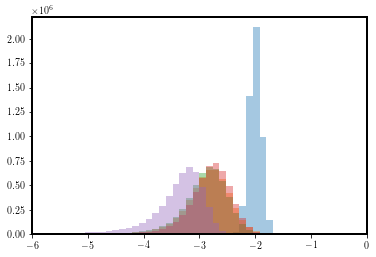

In [11]:
feh_err_upper = []
feh_err_lower = []

for measurement_index in range(len(valid_ews)):

    ew_measured = valid_ews[measurement_index]
    dew_tot_measured = valid_dews[measurement_index]
    M_V = valid_mv[measurement_index]
    dM_V = valid_dmv[measurement_index]
    
    ## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html
    a, b = (0 - ew_measured) / dew_tot_measured, (1e9 - ew_measured) / dew_tot_measured
    
    summed_ew_dist = truncnorm.rvs(a = a, b = b, loc =  ew_measured, scale = dew_tot_measured, size=5000000)
    MV_dist =   norm.rvs(loc = M_V, scale = dM_V, size= 5000000)
    carrera_a = norm.rvs(loc = car13_a, scale = car13_da, size=5000000)
    carrera_b = norm.rvs(loc = car13_b, scale = car13_db, size=5000000)
    carrera_c = norm.rvs(loc = car13_c, scale = car13_dc, size=5000000)
    carrera_d = norm.rvs(loc = car13_d, scale = car13_dd, size=5000000)
    carrera_e = norm.rvs(loc = car13_e, scale = car13_de, size=5000000)

    feh = carrera_a + carrera_b*MV_dist + carrera_c*summed_ew_dist + carrera_d*(1/summed_ew_dist**(1.5)) +  carrera_e*summed_ew_dist*MV_dist
    p16,p50,p84 = np.percentile(feh,[16,50,84])
    
    print(np.round(p50,3), '+', np.round(p84-p50,3), '-', np.round(p50-p16,3))
    
    plt.hist(feh, alpha = .4, bins = np.linspace(-6,0,51))

    plt.xlim(-6,0)
    
    feh_err_upper.append(p84-p50)
    feh_err_lower.append(p50-p16)

In [12]:
dataframe['FeH_err_upper'] = [-99] * len(dataframe)
dataframe['FeH_err_lower'] = [-99] * len(dataframe)

dataframe['FeH_err_upper'][dataframe['FeH'] != -99] = feh_err_upper
dataframe['FeH_err_lower'][dataframe['FeH'] != -99] = feh_err_lower

dataframe['FeH_err_mean'] = [np.mean([a,b]) for (a,b) in zip(dataframe['FeH_err_upper'], dataframe['FeH_err_lower'])]

# Derive Mean Metallicity and Metallicity Dispersion

### Likelihood Function

In [13]:
PARAMS = odict([
    ('mu',r'$\mu$ (dex)'),
    ('sigma',r'$\sigma$ (dex)'),
])

def quantile(x, q, weights=None):
    """
    Compute sample quantiles with support for weighted samples.
    Note
    ----
    When ``weights`` is ``None``, this method simply calls numpy's percentile
    function with the values of ``q`` multiplied by 100.
    Parameters
    ----------
    x : array_like[nsamples,]
       The samples.
    q : array_like[nquantiles,]
       The list of quantiles to compute. These should all be in the range
       ``[0, 1]``.
    weights : Optional[array_like[nsamples,]]
        An optional weight corresponding to each sample. These
    Returns
    -------
    quantiles : array_like[nquantiles,]
        The sample quantiles computed at ``q``.
    Raises
    ------
    ValueError
        For invalid quantiles; ``q`` not in ``[0, 1]`` or dimension mismatch
        between ``x`` and ``weights``.
    """
    x = np.atleast_1d(x)
    q = np.atleast_1d(q)

    if np.any(q < 0.0) or np.any(q > 1.0):
        raise ValueError("Quantiles must be between 0 and 1")

    if weights is None:
        return np.percentile(x, list(100.0 * q))
    else:
        weights = np.atleast_1d(weights)
        if len(x) != len(weights):
            raise ValueError("Dimension mismatch: len(weights) != len(x)")
        idx = np.argsort(x)
        sw = weights[idx]
        cdf = np.cumsum(sw)[:-1]
        cdf /= cdf[-1]
        cdf = np.append(0, cdf)
        return np.interp(q, cdf, x[idx]).tolist()


def lnprior(theta, vel, kwargs):
    """
    Log-prior to set the bounds of the parameter space:
      sigma > 0
      vmin < mu < vmax
    """
    sigmaprior = kwargs.get('sigmaprior')
    
    if sigmaprior == 'log':
        mu, logsigma = theta
        if not -2 < logsigma < 2:
            return -np.inf
    else:
        mu, sigma = theta
        if sigma < 0:
            return -np.inf

    return 0

def lnlike(theta, vel, vel_err, kwargs):
    """
    Log-likelihood function from Walker et al. (2007) Eq. :
    http://arxiv.org/abs/astro-ph/0511465
    """
    
    sigmaprior = kwargs.get('sigmaprior')
    if sigmaprior == 'log':
        mu, logsigma = theta
        sigma2 = (10**logsigma)**2
    else:
        mu, sigma = theta
        sigma2 = sigma**2

    a = -0.5 * np.sum(np.log(vel_err**2 + sigma2))
    b = -0.5 * np.sum((vel - mu)**2/(vel_err**2 + sigma2))
    c = -1. * (vel.size)/2. * np.log(2*np.pi)

    return a + b + c

def lnprob(theta, vel, vel_err, kwargs):
    
    lp = lnprior(theta, vel, kwargs)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, vel, vel_err, kwargs)

def mcmc(vel, vel_err, kwargs, showProgress = False):
    nperr = np.seterr(invalid='ignore')

    
    
    ndim = len(PARAMS)  # number of parameters in the model

#     print(kwargs)
    
    nwalkers = kwargs.get('nwalkers',50) # number of MCMC walkers
    nburn    = kwargs.get('nburn',500)    # "burn-in" period to let chains stabilize
    nsteps   = kwargs.get('nsteps',2500) # number of MCMC steps to take
    nthreads = kwargs.get('nthreads',1)  # number of threads
 
    sigmaprior = kwargs.get('sigmaprior','log') # prior on sigma: log or flat
    
#     print('here', sigmaprior)
    ## flat
    if not np.all(np.isfinite([vel,vel_err])):
        print("WARNING: Non-finite value found in data")
        sel = np.isfinite(vel) & np.isfinite(vel_err)
        vel,vel_err = vel[sel], vel_err[sel]

    mean, std = np.mean(vel), np.std(vel)
  
    mu = np.random.rand(nwalkers) * 0.5+(vel.mean())
    sigma = np.random.rand(nwalkers)*1.5

    if sigmaprior == 'log':
        starting_guesses = np.vstack([mu,np.log10(sigma)]).T
    else:
        starting_guesses = np.vstack([mu, sigma]).T

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob,
                                    args=[vel,vel_err,kwargs], threads=nthreads)

    # Burn the requested number of steps

    pos,prob,state = sampler.run_mcmc(starting_guesses,nburn, progress = showProgress)
    sampler.reset()

    #sampler.run_mcmc(pos,nsteps,state,prob)
    sampler.run_mcmc(pos,nsteps, progress = showProgress)
    samples = sampler.chain.reshape(-1,ndim,order='F')

    names = PARAMS.keys()

    return samples

### 1. Default 5-star sample, logarithmic prior

100%|██████████| 4500/4500 [04:47<00:00, 15.67it/s]


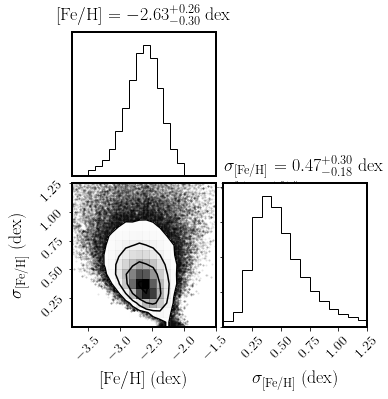

In [14]:
default_kwargs = dict(nwalkers = 50,nburn = 500,
                  nsteps = 4500 , nthreads= 4, sigmaprior = 'log')

valid_feh = dataframe['FeH'][dataframe['FeH'] != -99]
valid_dfeh = dataframe['FeH_err_mean'][dataframe['FeH'] != -99]

samples = mcmc(valid_feh, valid_dfeh, default_kwargs, showProgress = True)

vsamples = samples[:,0]
sigma_samples = 10**samples[:,1]
samples = np.vstack([vsamples,sigma_samples]).T

fig = corner.corner(samples,labels = [r'$[\rm Fe/H] \hspace{.25em} (\rm dex)$',r'$\sigma_{\rm [Fe/H]} \hspace{.25em} (\rm dex)$'], show_titles = False, title_kwargs=dict(fontsize=16.), label_kwargs=dict(fontsize=18), bins = [np.linspace(-3.5,-2,15),np.linspace(0,2,25)])


fig.axes[0].set_xlim(-3.75,-1.5)
fig.axes[2].set_xlim(-3.75,-1.5)
fig.axes[2].set_ylim(0,1.25)
fig.axes[3].set_xlim(0,1.25)
fig.axes[2].tick_params(axis='both', which='major', labelsize=14)
fig.axes[3].tick_params(axis='both', which='major', labelsize=14)

res_v50,res_v16,res_v84 = quantile(samples[:,0], q = [.5,.16,.84])
lowvbound = res_v50 - res_v16
upvbound = res_v84 - res_v50

res_d50,res_d16,res_d84 = quantile(samples[:,1], q = [.5,.16,.84])
lowdbound = res_d50 - res_d16
updbound = res_d84 - res_d50

fig.axes[0].set_xticks([-3.5,-3.1,-2.7,-2.3,-1.9,-1.5])
fig.axes[1].set_xticks([-3.5,-3.1,-2.7,-2.3,-1.9,-1.5])
fig.axes[0].set_title(r'$[\rm Fe/H] = %.2f^{+ %.2f}_{-%.2f} \hspace{.25em} \rm dex$'%(res_v50,upvbound,lowvbound), fontsize = 18, y = 1.04)
fig.axes[3].set_title(r'$ \hspace{.6em}  \sigma_{\rm [Fe/H]} = %.2f^{+ %.2f}_{-%.2f} \hspace{.25em} \rm dex$'%(res_d50,updbound,lowdbound), fontsize = 18, x = .56, y = 1.04)
fig.axes[0].tick_params(bottom = False, left = False)
fig.axes[1].tick_params(bottom = False)

plt.savefig('Revised_MetallicityResults.pdf', bbox_inches = 'tight')

### 2. Jackknife tests: removing stars one by one

In [15]:
default_kwargs = dict(nwalkers = 50,nburn = 5000,
                  nsteps = 4500 , nthreads= 4, sigmaprior = 'log')

sourceIDs = dataframe['source_id'][(dataframe['FeH'] != -99)]


for sID in sourceIDs:

    print('After removing Star %d: '%sID)
    exclude = (dataframe['source_id'] != sID)

    valid_feh = dataframe['FeH'][(dataframe['FeH'] != -99) & exclude]
    valid_dfeh = dataframe['FeH_err_mean'][(dataframe['FeH'] != -99) & exclude]

    samples = mcmc(valid_feh, valid_dfeh, default_kwargs)

    vsamples = samples[:,0]
    sigma_samples = 10**samples[:,1]
    samples = np.vstack([vsamples,sigma_samples]).T

    res_v50,res_v16,res_v84 = quantile(samples[:,0], q = [.5,.16,.84])
    lowvbound = res_v50 - res_v16
    upvbound = res_v84 - res_v50

    res_d50,res_d16,res_d84 = quantile(samples[:,1], q = [.5,.16,.84])
    lowdbound = res_d50 - res_d16
    updbound = res_d84 - res_d50                             
                                   

    print('Mean Metallicity is %.2f [+%.2f,-%.2f]'%(res_v50, lowvbound, upvbound))
    print('Metallcity Dispersion is %.2f [+%.2f,-%.2f]'%(res_d50, lowdbound, updbound))
    print('-'*40)

After removing Star 1796890071833434112: 
Mean Metallicity is -2.91 [+0.20,-0.20]
Metallcity Dispersion is 0.06 [+0.04,-0.17]
----------------------------------------
After removing Star 1796887219975171328: 
Mean Metallicity is -2.60 [+0.37,-0.32]
Metallcity Dispersion is 0.53 [+0.23,-0.43]
----------------------------------------
After removing Star 1796888907896667520: 
Mean Metallicity is -2.58 [+0.37,-0.32]
Metallcity Dispersion is 0.53 [+0.23,-0.44]
----------------------------------------
After removing Star 1796888834882857216: 
Mean Metallicity is -2.61 [+0.39,-0.33]
Metallcity Dispersion is 0.55 [+0.23,-0.43]
----------------------------------------
After removing Star 1796890381071133568: 
Mean Metallicity is -2.45 [+0.33,-0.27]
Metallcity Dispersion is 0.40 [+0.21,-0.35]
----------------------------------------
